#  作業

Hint: 人物原始邊框座標 (60, 40), (420, 510)

請根據 Lena 圖做以下處理

- 對明亮度做直方圖均衡處理
- 水平鏡像 + 縮放處理 (0.5 倍)
- 畫出人物矩形邊框

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt, gridspec

img = cv2.imread('./D00_lena.png')

## Hint: 矩形

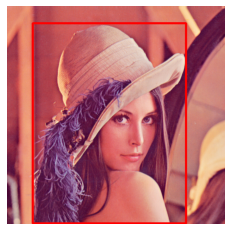

In [2]:
img_rect = img.copy()
cv2.rectangle(img_rect, (60, 40), (420, 510), (0, 0, 255), 3)
plt.imshow(img_rect[..., [2, 1, 0]])
plt.axis('off')
plt.show()

## Hint: 線

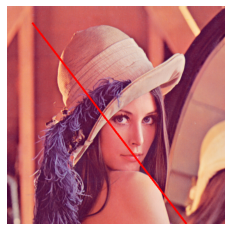

In [3]:
img_line = img.copy()
cv2.line(img_line, (60, 40), (420, 510), (0, 0, 255), 3)
plt.imshow(img_line[..., [2, 1, 0]])
plt.axis('off')
plt.show()

## Hint: 文字

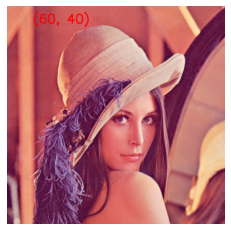

In [4]:
img_text = img.copy()
cv2.putText(img_text, '(60, 40)', (60, 40), 0, 1, (0, 0, 255), 2)
plt.imshow(img_text[..., [2, 1, 0]])
plt.axis('off')
plt.show()

##  解法二

如果希望得知矩型邊框的位置

1. 顏色的操作 (對明亮度做直方圖均衡)
2. 鏡像可以透過四則運算得知
3. 透過建構 transformation matrix 做縮放
4. 把矩型邊框的點與 transformation matrix 相乘就會得到縮放後的位置
5. 畫圖

得到的圖的結果正確，同時也知道新的矩型邊框座標點

Origin point1=[60, 40], Origin point2=[420, 510]
Resize point1=[46, 20], Resize point2=[226, 255]


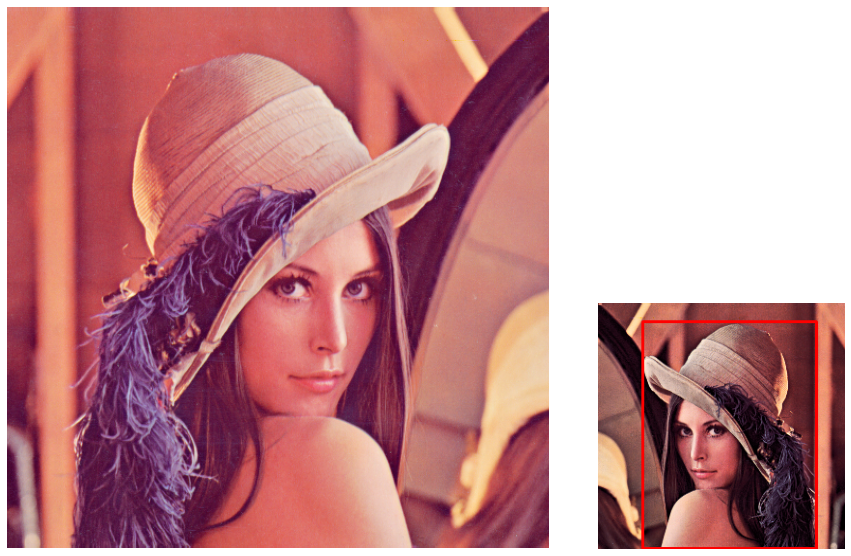

In [5]:
img_hw = img.copy()
point1 = [60, 40]
point2 = [420, 510]

"""
對明亮度做直方圖均衡
"""
# 原始 BGR 圖片轉 HSV 圖片
img_hw = cv2.cvtColor(img_hw, cv2.COLOR_BGR2HSV)

# 對明亮度做直方圖均衡 -> 對 HSV 的 V 做直方圖均衡
img_hw[..., 2] = cv2.equalizeHist(img_hw[..., 2])

# 將圖片轉回 BGR
img_hw = cv2.cvtColor(img_hw, cv2.COLOR_HSV2BGR)

"""
水平鏡像
"""
# 圖片鏡像
img_hw = img_hw[:, ::-1, :]

# 透過四則運算計算鏡像後位置
# 確保點的位置一樣是左上跟右下，所以交換鏡像後的 x 座標 (y 座標做水平鏡像後位置不變)
point1_flip, point2_flip = [img_hw.shape[1] - point2[0], point1[1]],[img_hw.shape[1] - point1[0], point2[1]]

"""
縮放處理 (0.5 倍)
"""
scale = 0.5
resize_shape = tuple(map(lambda x : int(x * scale), img_hw.shape[:2]))

# 建構 scale matrix
M_scale = np.float32(([scale, 0, 0], [0, scale, 0]))
img_hw = cv2.warpAffine(img_hw, M_scale, resize_shape)

# 把左上跟右下轉為矩陣型式
bbox = np.float32((point1_flip, point2_flip))

# 做矩陣乘法可以使用 `np.dot`, 為了做矩陣乘法, M_scale 需要做轉置之後才能相乘
scale_point1, scale_point2 = np.dot(M_scale.T, bbox).astype('uint8')[:2].tolist()

print(f'''Origin point1={point1}, Origin point2={point2}
Resize point1={scale_point1}, Resize point2={scale_point2}''')

"""
畫出人物矩形邊框
"""
cv2.rectangle(img_hw, scale_point1, scale_point2, (0, 0, 255), 2)

# 畫圖
plt.figure(figsize = (15,10))
gs = gridspec.GridSpec(2,3)
for i,x in enumerate([img,img_hw]):
    plt.subplot(gs[1,2] if i else gs[:,:2]).imshow(x[..., [2, 1, 0]])
    plt.axis('off')
plt.show()

##  解法三 (optional)

把矩型邊框用遮罩的方式呈現，使用同樣處理圖片的方式處理遮罩
最後再找遮罩的左上跟右下的點的位置

這邊會用到許多沒提過的東西，所以當作 optional

Origin point1=(60, 40), Origin point2=(420, 510)
Resize point1=(46, 20), Resize point2=(225, 254)


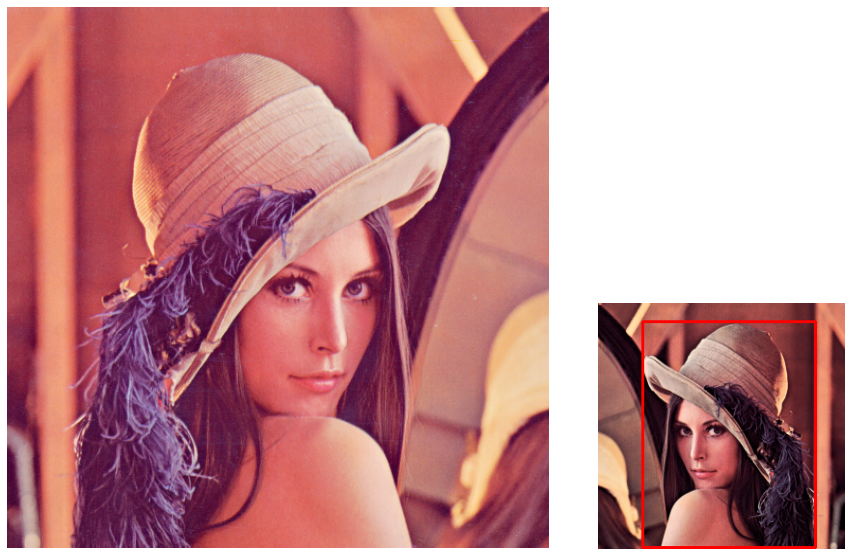

In [6]:
img_hw = img.copy()
point1 = (60, 40)
point2 = (420, 510)

# 2D mask
img_mask = np.zeros_like(img_hw)
img_mask[40:510, 60:420, ...] = 255

"""
對明亮度做直方圖均衡
"""
# 原始 BGR 圖片轉 HSV 圖片
img_hw = cv2.cvtColor(img_hw, cv2.COLOR_BGR2HSV)

# 對明亮度做直方圖均衡 -> 對 HSV 的 V 做直方圖均衡
img_hw[..., 2] = cv2.equalizeHist(img_hw[..., 2])

# 將圖片轉回 BGR
img_hw = cv2.cvtColor(img_hw, cv2.COLOR_HSV2BGR)

"""
水平鏡像 + 縮放處理 (0.5 倍)
"""
# 水平鏡像 (圖片) + 縮放處理
img_hw, img_mask = [cv2.resize(i[:, ::-1, :], None, fx=0.5, fy=0.5, interpolation=cv2.INTER_LINEAR) \
                    for i in [img_hw,img_mask]]

# 取得遮照的左上跟右下的點
# 這邊你可以發現 transformation matrix 跟雙線性差值的結果會有一點點差異
scale_point1, scale_point2= [tuple(map(i,(np.where(img_mask)[-2::-1]))) for i in [min,max]]

print(f'''Origin point1={point1}, Origin point2={point2}
Resize point1={scale_point1}, Resize point2={scale_point2}''')

"""
畫出人物矩形邊框
"""
cv2.rectangle(img_hw, scale_point1, scale_point2, (0, 0, 255), 2)

# 畫圖
plt.figure(figsize = (15,10))
gs = gridspec.GridSpec(2,3)
for i,x in enumerate([img,img_hw]):
    plt.subplot(gs[1,2] if i else gs[:,:2]).imshow(x[..., [2, 1, 0]])
    plt.axis('off')
plt.show()